# MSD vectorization

This notebook tries to vectorize the MSD calculation from Cristian, to speed up the analysis.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import pandas as pd

## 1 load trajectory data

In [108]:
# load a trajectory
traj_r = pd.read_csv(r'C:\Users\liuzy\Dropbox\Fluctuation Bacterial Droplets\Data\exp1.csv', names=['x', 'y', 'z'])
traj = np.array(traj_r)
# traj = np.random.rand(2000, 3)

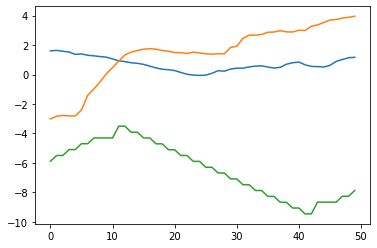

In [109]:
plt.plot(traj[:50, 0])
plt.plot(traj[:50, 1])
plt.plot(traj[:50, 2])

## 2 Trackpy.msd

In [114]:
## trackpy
t = traj_r.assign(particle=0, frame=traj_r.index)
msd = tp.msd(t, mpp=1, fps=1, pos_columns=['x', 'y', 'z'], max_lagtime=len(t))

## 3 Nested for loops

In [111]:
%%time 
## brutal method
msd_x = []
msd_y = []
msd_z = []
for i in range(0, len(traj[:, 0])):
    sum_x = 0
    sum_y = 0
    sum_z = 0
    n = len(traj[:, 0]) - i
    for j in range(0, n):
        sum_x += (traj[i+j, 0] - traj[j, 0]) ** 2
        sum_y += (traj[i+j, 1] - traj[j, 1]) ** 2
        sum_z += (traj[i+j, 2] - traj[j, 2]) ** 2
    msd_x.append(sum_x/n)
    msd_y.append(sum_y/n)
    msd_z.append(sum_z/n)

Wall time: 5min 38s


## 4 Vectorized

In [112]:
%%time
## vectorized code
msd_list = []
for i in range(0, len(traj[:, 0])):
    shifted = np.roll(traj, i, axis=0)
    shifted[:i, :] = np.nan
    diff = traj - shifted
    diff_msq = np.nanmean((diff ** 2), axis=0)
    msd_list.append(diff_msq)

msd_a = np.array(msd_list)

Wall time: 4.07 s


[]

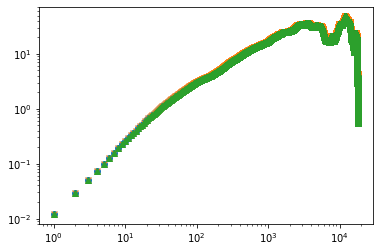

In [115]:
plt.plot(msd_x, marker='o', ls='')
plt.plot(msd['<x^2>'], marker='x', ls='')
plt.plot(msd_a[:, 0], marker='^', ls='')
plt.loglog()

```matlab
function [MSD_X,MSD_Y,MSD_Z,MSD,t_MSD] = msd_Gotaxyz(xc,yc,zc,fps)

X = xc;
Y = yc;
Z=zc;
%   MSD_X =zeros(1,length(X)/10);
%   MSD_Y = zeros(1,length(X)/10);
%   MSD_Z = zeros(1,length(X)/10);
%   MSD=zeros(1,length(X)/10);
for i = 1: length(X)/10%length(X)-1 % Recorro desde el primero hasta el penúltimo, para tener una diferencia. (Último con último == 0)  Para grabaciones cerca dejar en length(X)/10

    Suma_X = 0;
    Suma_Y = 0;
    Suma_Z=0;
    for j = 1:length(X)-i % Me voy separando de l en l. Si estoy parado en el elemento i, la máxima separación que me lleva al último elemento es length(X)-i
    
        Suma_X = Suma_X + (X(i+j) -X(j))^2; 
        Suma_Y = Suma_Y + (Y(i+j) -Y(j))^2; 
        Suma_Z = Suma_Z + (Z(i+j) -Z(j))^2; 

    end
    
    MSD_X(i) = Suma_X/(length(X)-i);
    MSD_Y(i) = Suma_Y/(length(X)-i);
    MSD_Z(i) = Suma_Z/(length(X)-i);

    MSD(i) = (Suma_X+Suma_Y+Suma_Z)/(length(X)-i);
    
end

% Para analisis gotas cerca volver a ponerlo
 MSD_X = [0,MSD_X] ;
 MSD_Y = [0,MSD_Y];
 MSD_Z=[0,MSD_Z];
 MSD = [0,MSD];

if length(fps) == 1

%linspace(0,length(X),length(X))/fps;
%t_MSD=(0:length(MSD)-1)/fps;
t_MSD=(0:length(MSD)-1)/fps;

else
    
%t_MSD=(0:length(MSD)-1)/mean(fps);
t_MSD=(0:length(MSD)-1)/mean(fps);
    
end


```